# Today you are a MLE@Samsung Research and your goal is to perform segmentation of cystic regions from OCT images.
## This work is based on the recent publication https://arxiv.org/abs/2008.02952
## This model is adapted from the original codebase in https://github.com/sohiniroych/U-net_using_TF2

# Optical Coherence Tomography (OCT) images represent grayscale images representing the depth of retina. Cystic regions are gaps in the retina as shown below
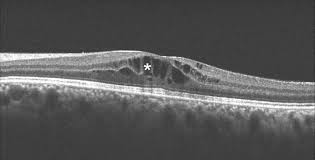

## Yor goal is to segment the cysts (dark gaps) in the images using the U-net model.

# Your Deliverables are as follows:
### 1. Train a u-net model from scratch and test performance on test images for 2 OCT repos.
### 2. Vary the loss function, kernel dialation, depthwise separable kernels and report results.
### 3. Report observations with and without Batch normalization and Dropout at test time.
### 4. If you use Dropout at test time and generate 2-3 test predictions, what do you observe from these predictions? 

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
%cd gdrive/MyDrive/'Colab Notebooks'

/content/gdrive/MyDrive/Colab Notebooks


# Task 1: Implement U-net model from scratch for the 'cirrus_3' data set. Report performance on test set and save the model as 'unet_cirrus.hdf5'
## [Instructor Led]

## Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [9]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc

In [11]:
#Define Additional loss functions for Task 2
def dice_coef(y_true, y_pred, smooth=1):
    intersection = keras.sum(y_true * y_pred, axis=[1,2,3])
    union = keras.sum(y_true, axis=[1,2,3]) + keras.sum(y_pred, axis=[1,2,3])
    return keras.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
#Step 2: Define the U-net model
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [13]:
#All additional functions for data prep and evaluation are housed in unet_helper_finctions.py
from unet_helper_functions import *

## All definitions are now done! Lets start using the functions now...
## B. Call to image data generator, model initialization, followed by model fitting.

__You can use the following code to unzip Data if you haven't done so__

In [8]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
   creating: Data/cirrus_3/
   creating: Data/cirrus_3/train/
   creating: Data/cirrus_3/train/Image/
  inflating: Data/cirrus_3/train/Image/bscan_100.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_101.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_102.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_103.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_104.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_122.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_105.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_106.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_107.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_108.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_109.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_110.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_111.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_112.jpg  
  inflating: Data/cirrus_3/train/Image/bscan_113.jpg  
  inflating: Data/cirrus_3/train/Im

In [14]:
#Step 1: Call to image data generator in keras
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='./Data/cirrus_3/train/'

In [15]:
if not os.path.exists(PATH+'aug'):
    os.makedirs(PATH+'aug')
    
if not os.path.exists('./Data/cirrus_3/test/'+'pred'):
    os.makedirs('./Data/cirrus_3/test/'+'pred')

# the trainGenerator function is defined in the helpers file  
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'aug')

In [16]:
#Step 2: Initialize the model. Train from scratch!
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
#Step 3: Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard

# if you don't have the logs folder, make sure you create one:
if not os.path.exists(PATH+'aug'):
    os.makedirs('logs/fit/')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
#Step 4: Fit the u-net model
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_cirrus.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1)#callbacks=[tensorboard_callback])
# you can load the saved model using:
# model.load_weights('unet_cirrus.hdf5')

Found 91 images belonging to 1 classes.
Found 91 images belonging to 1 classes.
Epoch 1/50
15/15 [==============================] - 89s 3s/step - loss: 0.1551 - accuracy: 0.9454
Epoch 2/50
15/15 [==============================] - 10s 656ms/step - loss: 0.0712 - accuracy: 0.9712
Epoch 3/50
15/15 [==============================] - 11s 695ms/step - loss: 0.0610 - accuracy: 0.9747
Epoch 4/50
15/15 [==============================] - 10s 667ms/step - loss: 0.0552 - accuracy: 0.9779
Epoch 5/50
15/15 [==============================] - 11s 729ms/step - loss: 0.0530 - accuracy: 0.9786
Epoch 6/50
15/15 [==============================] - 10s 683ms/step - loss: 0.0509 - accuracy: 0.9792
Epoch 7/50
15/15 [==============================] - 12s 736ms/step - loss: 0.0483 - accuracy: 0.9800
Epoch 8/50
15/15 [==============================] - 11s 716ms/step - loss: 0.0464 - accuracy: 0.9810
Epoch 9/50
15/15 [==============================] - 12s 772ms/step - loss: 0.0453 - accuracy: 0.9811
Epoch 10/50
15

In [ ]:
%tensorboard --logdir logs/fit

## C. Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [19]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('./Data/cirrus_3/test/Image/')
#Return model outcome for each test image
results = model.predict(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!
saveResult('./Data/cirrus_3/test/Image/','./Data/cirrus_3/test/pred/',results)

48/48 [==============================] - 11s 228ms/step


/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_185.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_173.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_179.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_183.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/t

In [20]:
#Step 2: Evaluate the predicted outcome
gt_path='./Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

Precision= 0.23393743019628788 Recall= 0.7545958191200682 IoU= 0.21477866480188149 acc= 0.9833246866861979 F1= 0.32515481775580896


# Task 2: For unet model definition, vary the following 
# Tip: (Divide and conquer for solving these tasks at Breakout!):
## 1. Kernels (dialated kernels), 
## 2. Separable filters. Check syntax at: (https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D)
## 3. Loss function (to dice coefficient) and rerun whole process. Does it improve test performance?
### Enter your results in the table below

```
U-net Parameters  (cirrus_3)          | Precision|Recall|IoU   |acc   |F1    |
-------------------------------------------------------------------------------
3x3 kernels, binary cross entropy loss|           |     |      |      |      |
------------------------------------------------------------------------------
5x5 dilated kernels,cross-entropy loss|           |     |      |      |      |
------------------------------------------------------------------------------
3x3, depthwise                        |           |     |      |      |      |
separable kernels,dice_coef loss      |           |     |      |      |      |
------------------------------------------------------------------------------
````

In [21]:
#Step 2: Define the U-net model with dialation rate
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [22]:
#Step 2: Initialize the model. Train from scratch!
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 256, 256, 64) 256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_10[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
#Step 4: Fit the u-net model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_cirrus3.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1)#callbacks=[tensorboard_callback])
# you can load the saved model using:
# model.load_weights('unet_cirrus.hdf5')

Epoch 1/50
15/15 [==============================] - 13s 724ms/step - loss: 0.5064 - accuracy: 0.9099
Epoch 2/50
15/15 [==============================] - 11s 722ms/step - loss: 0.0972 - accuracy: 0.9503
Epoch 3/50
15/15 [==============================] - 11s 762ms/step - loss: 0.0793 - accuracy: 0.9494
Epoch 4/50
15/15 [==============================] - 11s 756ms/step - loss: 0.0717 - accuracy: 0.9496
Epoch 5/50
15/15 [==============================] - 12s 792ms/step - loss: 0.0705 - accuracy: 0.9504
Epoch 6/50
15/15 [==============================] - 12s 765ms/step - loss: 0.0704 - accuracy: 0.9488
Epoch 7/50
15/15 [==============================] - 12s 767ms/step - loss: 0.0660 - accuracy: 0.9503
Epoch 8/50
15/15 [==============================] - 11s 736ms/step - loss: 0.0662 - accuracy: 0.9493
Epoch 9/50
15/15 [==============================] - 11s 761ms/step - loss: 0.0651 - accuracy: 0.9496
Epoch 10/50
15/15 [==============================] - 11s 742ms/step - loss: 0.0624 - accura

In [25]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('./Data/cirrus_3/test/Image/')
#Return model outcome for each test image
results = model.predict(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!


48/48 [==============================] - 2s 33ms/step


In [26]:
saveResult('./Data/cirrus_3/test/Image/','./Data/cirrus_3/test/pred/',results)

/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_159.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_163.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_167.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_155.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/t

In [27]:
#Step 2: Evaluate the predicted outcome
gt_path='./Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:178: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
/content/gdrive/MyDrive/Colab Notebooks/unet_helper_functions.py:140: RuntimeWarning: invalid value encountered in double_scalars
  prec=tp/(tp+fp)


Precision= nan Recall= 0.20710662603786736 IoU= 0.13700531191977283 acc= 0.9929599761962891 F1= 0.20241727520915284


In [28]:
#Step 2: Define the U-net model with depth wise layer
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = DepthwiseConv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = DepthwiseConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = DepthwiseConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = DepthwiseConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = DepthwiseConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = DepthwiseConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = DepthwiseConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = DepthwiseConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = DepthwiseConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [29]:
#Step 2: Initialize the model. Train from scratch!
model = unet()
model.summary()

ValueError: ignored

In [ ]:
#Step 4: Fit the u-net model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_cirrus3b.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1)#callbacks=[tensorboard_callback])
# you can load the saved model using:
# model.load_weights('unet_cirrus.hdf5')

In [ ]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('./Data/cirrus_3/test/Image/')
#Return model outcome for each test image
results = model.predict(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!

In [ ]:
saveResult('./Data/cirrus_3/test/Image/','./Data/cirrus_3/test/pred/',results)

In [ ]:
#Step 2: Evaluate the predicted outcome
gt_path='./Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

In [30]:
#Step 2: Define the U-net model Dice coef and loss
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'dice_coef_loss', metrics = 'dice_coef')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [31]:
#Step 2: Initialize the model. Train from scratch!
model = unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 64) 256         conv2d_49[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_26[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [33]:
#Step 4: Fit the u-net model
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_cirrus3d.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1)#callbacks=[tensorboard_callback])
# you can load the saved model using:
# model.load_weights('unet_cirrus.hdf5')

Epoch 1/50


ValueError: ignored

In [ ]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('./Data/cirrus_3/test/Image/')
#Return model outcome for each test image
results = model.predict(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!

In [ ]:
#Step 2: Evaluate the predicted outcome
gt_path='./Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

## Save the model with "best" performance above as unet_cirrus3.hdf5 model!

# Task 3: Perform transfer learning with 'unet_cirrus3.hdf5' as base weights and retrain on the 'nidek1' data set. Your training should take fewer epochs now. Report performace using 3x3 kernels with cross entropy loss.

### Hint: To load a previously save model that has custom loss functions use the following commands:

from tensorflow.keras.models import load_model

dependencies = {
    'dice_coef_loss': dice_coef_loss
}

model=load_model('unet_cirrus3.hdf5',custom_objects=dependencies)

# Task 4: Analyze the importance of BatchNormalization:
## For the Nidek1 dataset, remove all BatchNormalization commands and test the model.
## Next, add more batch normalizations after each conv2D layer for decoder networks and test the model.
## Report how useful Batchnormalization is.



# **Summary and Discussion:** **Discuss** "What would you report back as the BEST method for semantic segmentation?" 
# Think in terms of Data, Process and Outcomes specifically.
## Consider the following:
1. Medical data sets typically require high Recall, since missing data (false negatives) is detrimental. False positives (in terms of low precision) can be tolerated since the therapist/doctor will look at the outcome.
2. For semantic segmenation, high IoU and F-1 score is preferred, since it ensures the region of interst (cyst in this case) is well located.
3. Accuracy is NOT an important metric in semantic segmentation since false negatives are not that important.
4. Medical images are sensitive to training data so picking a represntative tarining data set is cruciual.

# Now what method (hyperparameters) results in BEST model. 
Share screen and discuss findings. Think about generalizability (something that works across data sets).



## Once you have mastered Binary Semantic Segmentation using U-net, you may consider extensions to multi-class segmentation using the following:
## 1. Blog: https://towardsdatascience.com/a-machine-learning-engineers-tutorial-to-transfer-learning-for-multi-class-image-segmentation-b34818caec6b

## 2. Video Lecture: https://youtu.be/ihq1Fg-KY5k

|Model type   |Precision   |Recall   |IOU   |ACC   |F1   |
|---|---|---|---|---|---|
|Base   |0.234   |0.754   | 0.214  |0.983   |0.325   |
|Dialeted kernel   |nan   |0.207   |0.137   |0.993   |0.202   |